In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from ipywidgets import interact

In [2]:
def read_tiff(path):
    return np.array(Image.open(path))

In [3]:
#configs
root_path = "/media/lazari/Al_AM_P06/process/"
sample_name = "08_alloy_C_lamella_A_roco"
lookup_t = pd.read_excel(r"/media/lazari/Al_AM_P06/logbook_look_up_table.xlsx",
    sheet_name='Alloy C Lamella A')
scan_detail = 'jmesh ROI2'
exclude_scan_nrs = np.array([400])
scan_nrs = lookup_t['Scan Number'][lookup_t['Scan details'] == scan_detail]
hours = np.array(lookup_t['Time (hrs)'][lookup_t['Scan details'] == scan_detail])
temps = np.array(lookup_t['Temperature'][lookup_t['Scan details'] == scan_detail])
temperature = 375
mask = np.logical_and( ~scan_nrs.isin(exclude_scan_nrs), temps==375)

scan_nrs = scan_nrs[mask]
hours = hours[mask]
temps = temps[mask]



images = {'Al-Ka' : None , 'Mn_Ka' : None, 'Cr_Ka' : None}

for element in images:  
    images[element] = []
    folder_path = os.path.join(root_path,sample_name, 'fluo_stacks', scan_detail, element, 'aligned_cv2')
    for s in scan_nrs[:]:
        images[element].append(read_tiff(os.path.join(folder_path,  f'{s}.tif')))

In [4]:

from matplotlib.patches import Rectangle
vmin =0
vmax = 200
col_roi = 40
row_roi = 130
box_width = 50
@interact(im_nr=(0,len(images['Mn_Ka'])-1, 1), element=images.keys(), vmin=(0,1000, 1), vmax=(10,1000,1),row_roi=(0, images['Mn_Ka'][0].shape[0], 1), col_roi=(0,images['Mn_Ka'][0].shape[1], 1), box_width=(0, images['Mn_Ka'][0].shape[0], 1))

def plot_im(im_nr, element, vmin , vmax, row_roi, col_roi, box_width):
    plt.figure(figsize=(8,8))
    plt.imshow(images[element][im_nr],vmin=vmin, vmax=vmax,cmap='hot', origin='upper')
    
    #plt.imshow(np.log(images[im_nr]), vmin=3,vmax=6.5)
    plt.title(f'{element}. t: {hours[im_nr]} h')
    plt.axis('off')
    ax = plt.gca()
    
    ax.add_patch(Rectangle((col_roi,row_roi), box_width,box_width, fill=False))
    

    
    plt.colorbar()

interactive(children=(IntSlider(value=11, description='im_nr', max=23), Dropdown(description='element', option…

In [5]:
crop_row = 12
crop_col = 2
box_width=78

In [6]:
#crop to exclude black areas
for element in images:
    images[element] = np.array(images[element])
    im = images[element][:, crop_row:crop_row+box_width, crop_col:crop_col+box_width]
    images[element] = im[0:-1] # remove last image which was corrupted
    


hours = hours[:-1]


In [7]:

@interact(im_nr=(0,len(images['Mn_Ka'])-1, 1), element=images.keys(), vmin=(0,1000, 1), vmax=(10,1000,1))

def plot_im(im_nr, element, vmin , vmax):
    plt.figure(figsize=(8,8))
    plt.imshow(images[element][im_nr],vmin=vmin, vmax=vmax,cmap='hot', origin='upper')
    
    #plt.imshow(np.log(images[im_nr]), vmin=3,vmax=6.5)
    #plt.title(f'{element}. t: {hours[im_nr]} h')
    plt.axis('off')
    
    

    
    plt.colorbar()

interactive(children=(IntSlider(value=11, description='im_nr', max=22), Dropdown(description='element', option…

In [8]:
images['Mn_Ka'].shape

(23, 78, 78)

In [45]:
def plot_pixel_time_series(time, data, name=None):
    import matplotlib as mpl
    data_shape =data.shape 
    if len(data_shape)>2:
        data = np.reshape(data, [data_shape[0], data_shape[1]*data_shape[2]])
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.plot(hours, data, alpha=0.01)
    plt.title('Pixel intensity of every pixel')
    plt.subplot(1,2,2)
    plt.plot(hours, data[:,::10], alpha=0.5)

    plt.title('Pixel intensity of every 10th pixel')
    plt.xlabel('t (h)')
    ax = plt.gca()
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    plt.ylabel('Intensity (a.u.)')
    if name:
        plt.suptitle(name)
    plt.show()




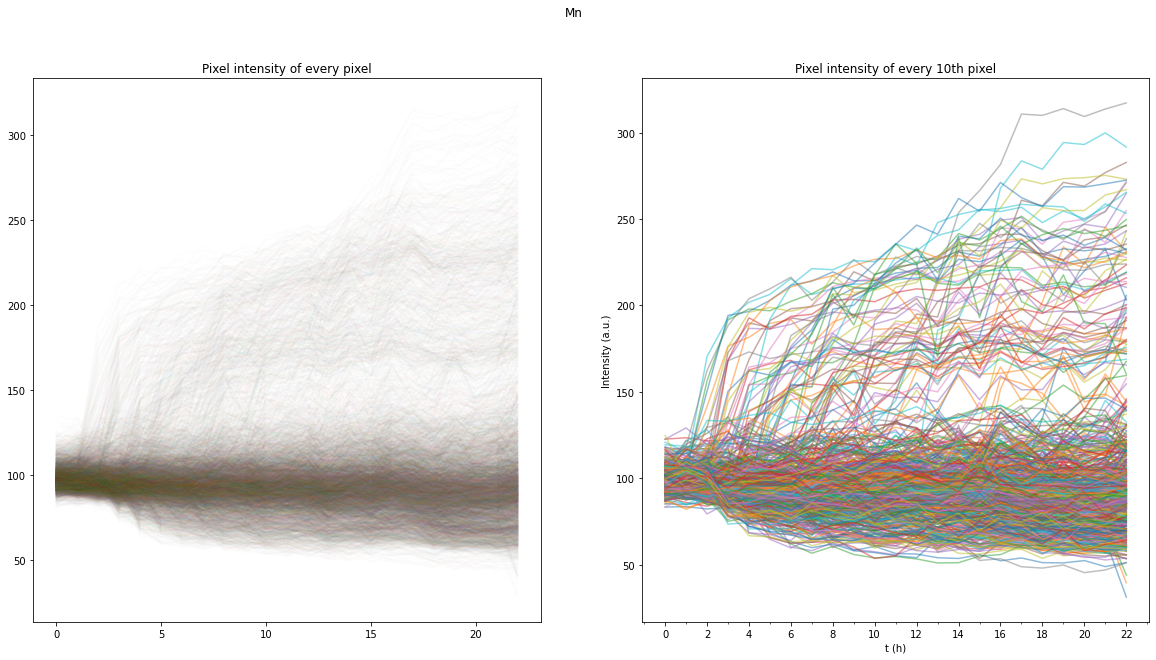

In [46]:

plot_pixel_time_series(hours, images['Mn_Ka'], 'Mn')

In [47]:
def smooth_time_series(data, window_size):
    data_shape =data.shape 
    if len(data_shape)>2:
        data = np.reshape(data, [data_shape[0], data_shape[1]*data_shape[2]])
    return pd.DataFrame(data).rolling(window=window_size).mean().to_numpy()

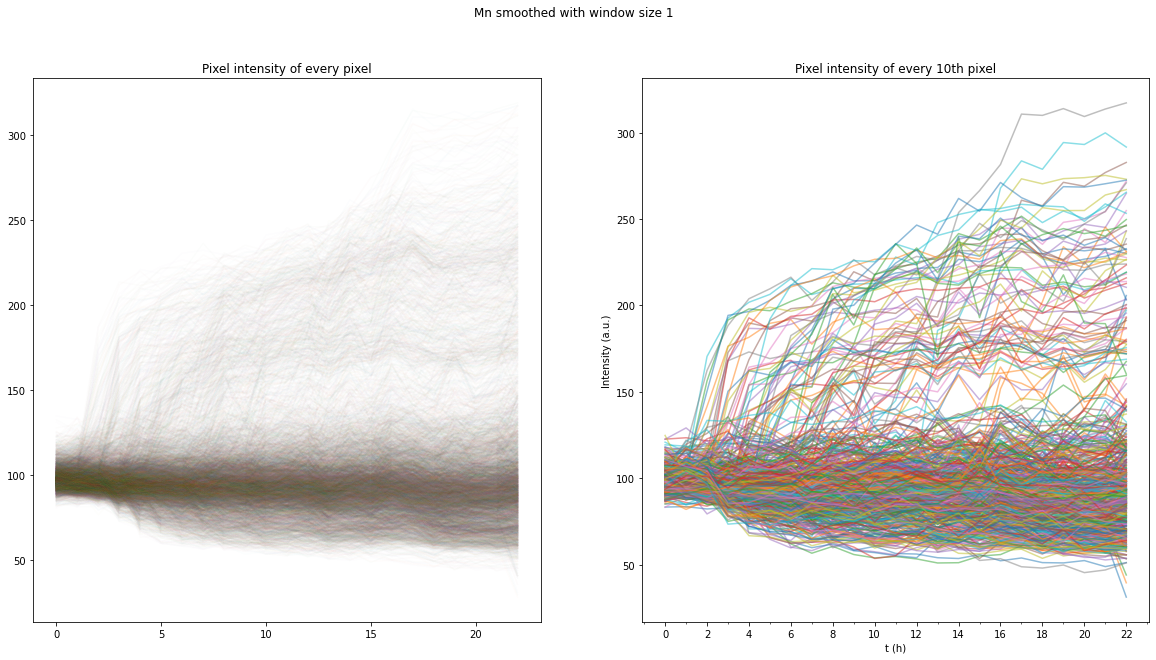

In [48]:
window_size =1
smoothed_Mn = smooth_time_series(images['Mn_Ka'], window_size)
plot_pixel_time_series(hours, smoothed_Mn, f'Mn smoothed with window size {window_size}')

In [36]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

range_to_test = np.arange(2,20)
for n_clusters in range_to_test:
    
    
    model = KMeans(n_clusters=n_clusters)
    model.fit(smoothed_Mn.T[:,window_size-1:])
    cluster_labels = model.labels_
    # Calculate the silhouette score of the clustering
    silhouette_avg = silhouette_score(smoothed_Mn.T[:,window_size-1:], cluster_labels)
    print(f'Sillhuette for {n_clusters} clusters: {silhouette_avg}')


Sillhuette for 2 clusters: 0.7594611645611468
Sillhuette for 3 clusters: 0.40587794653906784
Sillhuette for 4 clusters: 0.3573696561576501
Sillhuette for 5 clusters: 0.3213662299551775
Sillhuette for 6 clusters: 0.3275416689140807
Sillhuette for 7 clusters: 0.2843594371448524
Sillhuette for 8 clusters: 0.26624100437152226
Sillhuette for 9 clusters: 0.26695796152396994
Sillhuette for 10 clusters: 0.23791877269613076
Sillhuette for 11 clusters: 0.24406965173355308
Sillhuette for 12 clusters: 0.24473105750345633
Sillhuette for 13 clusters: 0.24687608371613792
Sillhuette for 14 clusters: 0.24008114709062203
Sillhuette for 15 clusters: 0.20907791058171604
Sillhuette for 16 clusters: 0.19627731451283364
Sillhuette for 17 clusters: 0.19923073369152766
Sillhuette for 18 clusters: 0.200743233631837
Sillhuette for 19 clusters: 0.19367587126907213


In [37]:
n_clusters = 9
Mn_cluster_model = KMeans(n_clusters=n_clusters)
Mn_cluster_model.fit(smoothed_Mn.T[:,window_size-1:])

KMeans(n_clusters=9)

In [76]:
def plot_cluster_results(model, hours, data_shape, name=None):
    from matplotlib import cm
    import matplotlib.colors as colors
    import matplotlib as mpl
    cmap_ = cm.Set1_r
   
    # Define the normalization for the colormap
    norm = colors.Normalize(vmin=0, vmax=model.labels_.max())
    # Map the cluster labels to colors using the colormap and normalization
    cluster_colors = cmap_(norm(model.labels_.reshape([data_shape[0], data_shape[1]])))
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.imshow(cluster_colors, cmap=cmap_)
    plt.title('Cluster labels')

    plt.subplot(1,2,2)

    for idx,center in enumerate(model.cluster_centers_):
        plt.plot(hours[window_size-1:], center.T, label=f'Cluster {idx}', color=cmap_(norm(idx)), linewidth=4)
    plt.xlabel('t (h)')
    plt.title('Cluster mean')
    ax = plt.gca()
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    if name:
        plt.suptitle(name)
    plt.legend()


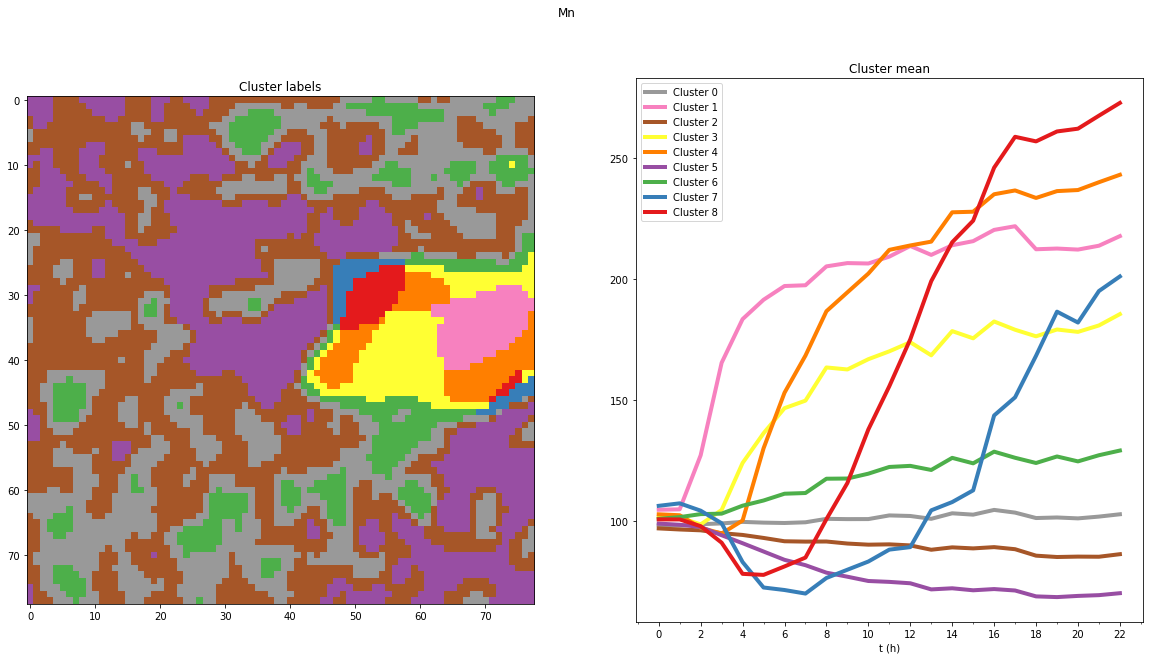

In [77]:
plot_cluster_results(Mn_cluster_model, hours, images['Mn_Ka'][0].shape, 'Mn')

# Cr clustering

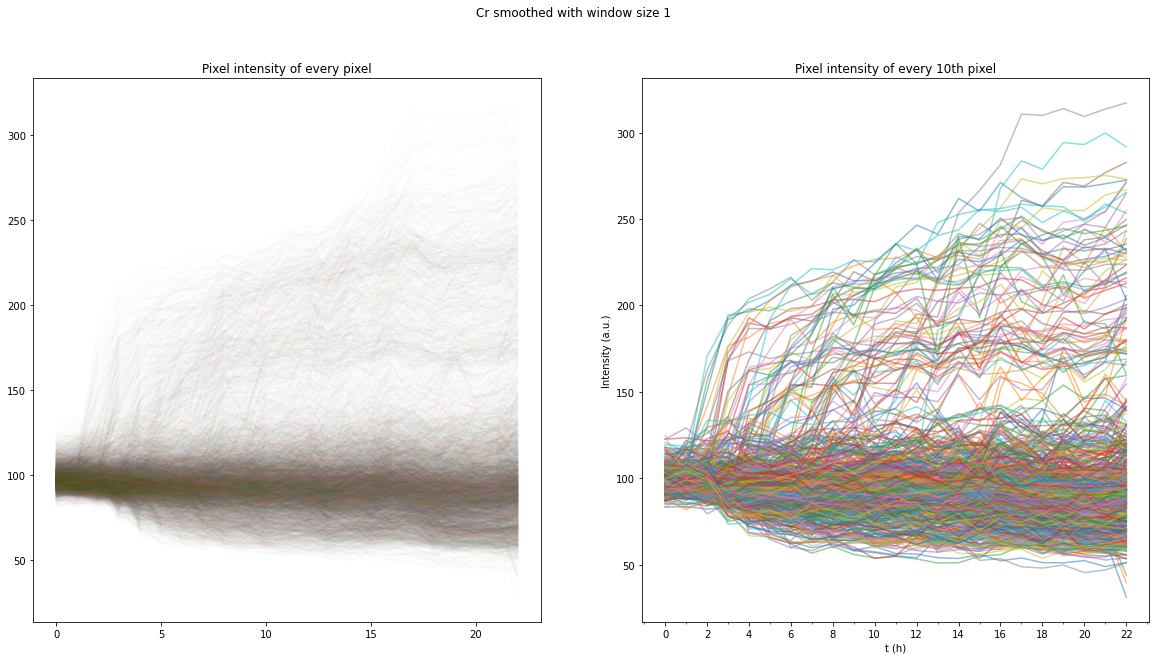

In [78]:
window_size =1
smoothed_Cr = smooth_time_series(images['Cr_Ka'], window_size)
plot_pixel_time_series(hours, smoothed_Mn, f'Cr smoothed with window size {window_size}')

In [79]:
n_clusters = 9
Cr_cluster_model = KMeans(n_clusters=n_clusters)
Cr_cluster_model.fit(smoothed_Cr.T[:,window_size-1:])

KMeans(n_clusters=9)

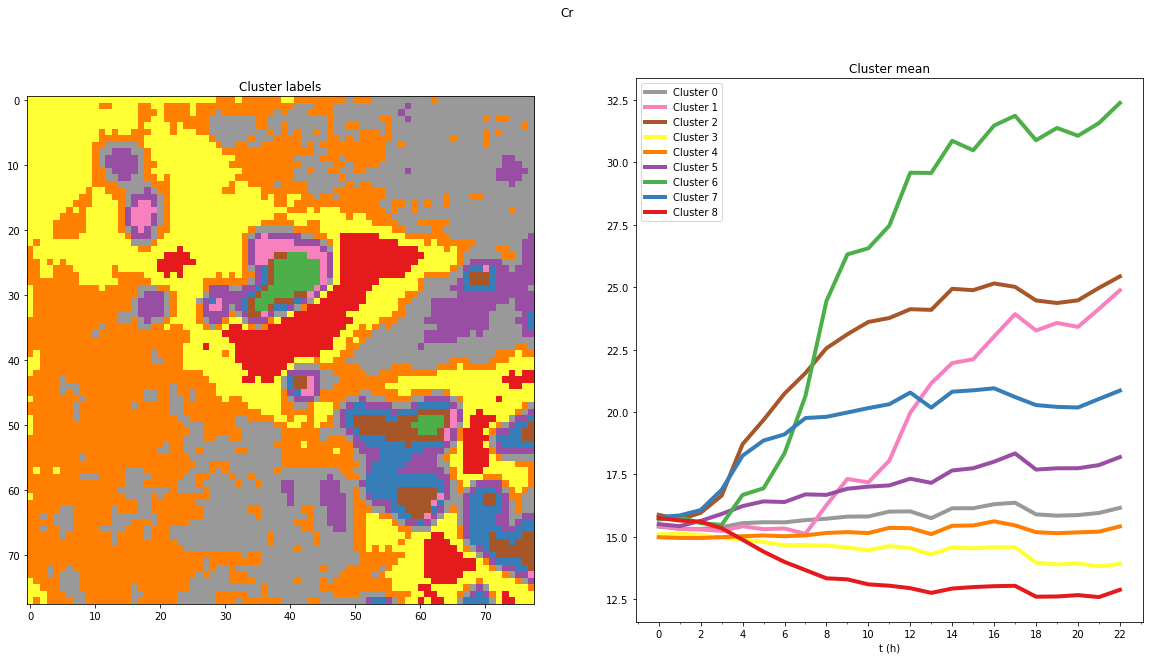

In [80]:
plot_cluster_results(Cr_cluster_model, hours, images['Cr_Ka'][0].shape, 'Cr')

# Clustering Cr/Mn fractions 

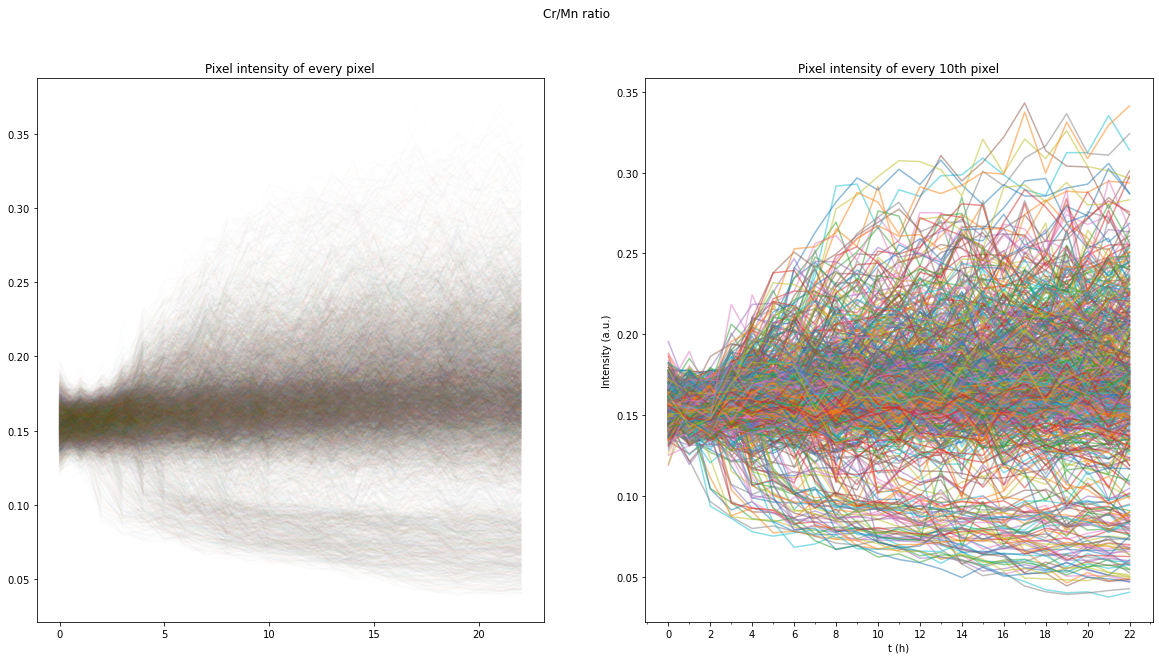

In [81]:
Cr_to_Mn = images['Cr_Ka']/images['Mn_Ka']
plot_pixel_time_series(hours, Cr_to_Mn, 'Cr/Mn ratio')

In [82]:
window_size = 1
smoothed_Cr_to_Mn = smooth_time_series(Cr_to_Mn, window_size)
n_clusters = 9
Cr_Mn_cluster_model = KMeans(n_clusters=n_clusters)
Cr_Mn_cluster_model.fit(smoothed_Cr_to_Mn.T[:,window_size-1:])

KMeans(n_clusters=9)

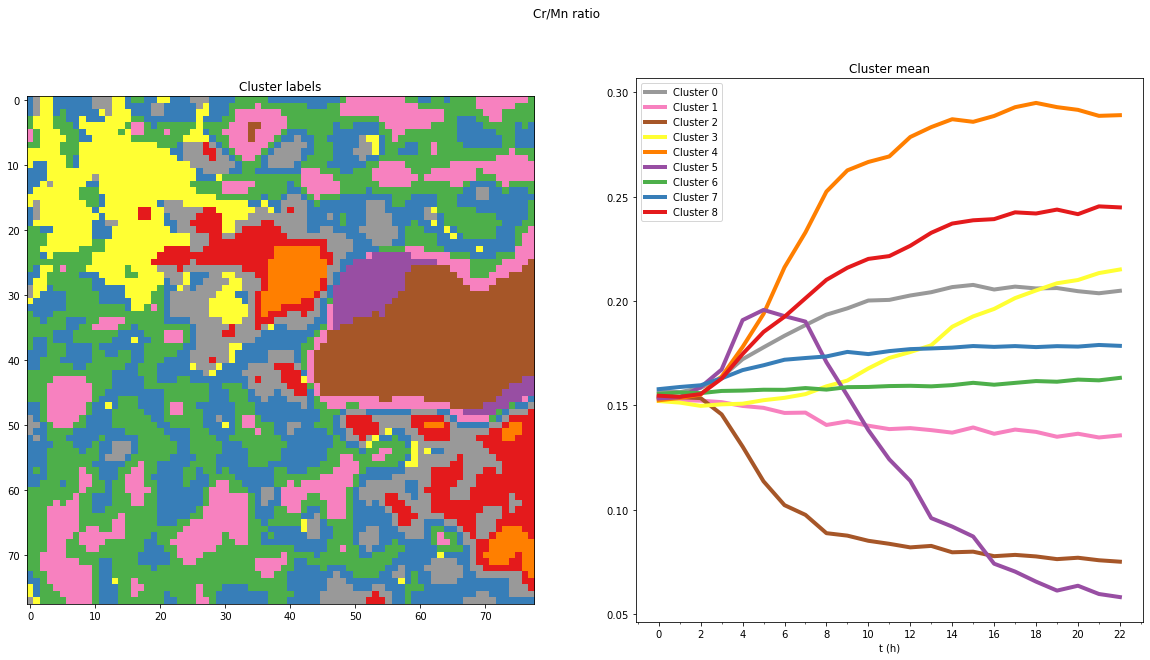

In [83]:
plot_cluster_results(Cr_Mn_cluster_model, hours, images['Cr_Ka'][0].shape, 'Cr/Mn ratio')

# Clustering Al

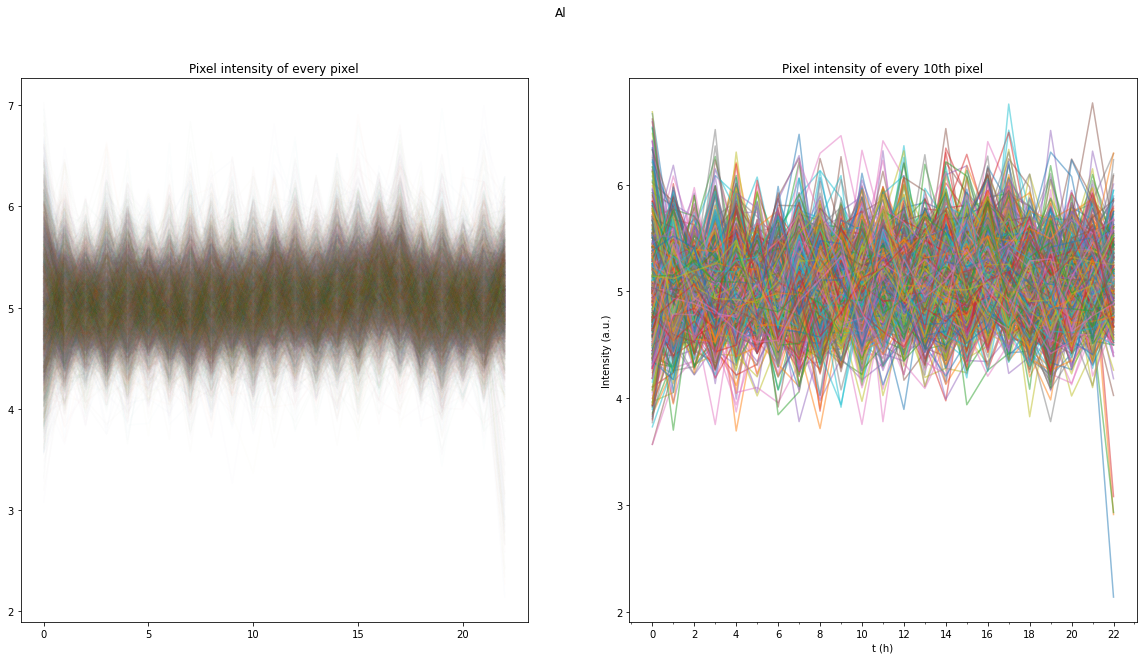

In [84]:
plot_pixel_time_series(hours, images['Al-Ka'], 'Al')

In [85]:
smoothed_Al = smooth_time_series(images['Al-Ka'], window_size)
n_clusters = 6
Al_cluster_model = KMeans(n_clusters=n_clusters)
Al_cluster_model.fit(smoothed_Al.T[:,window_size-1:])

KMeans(n_clusters=6)

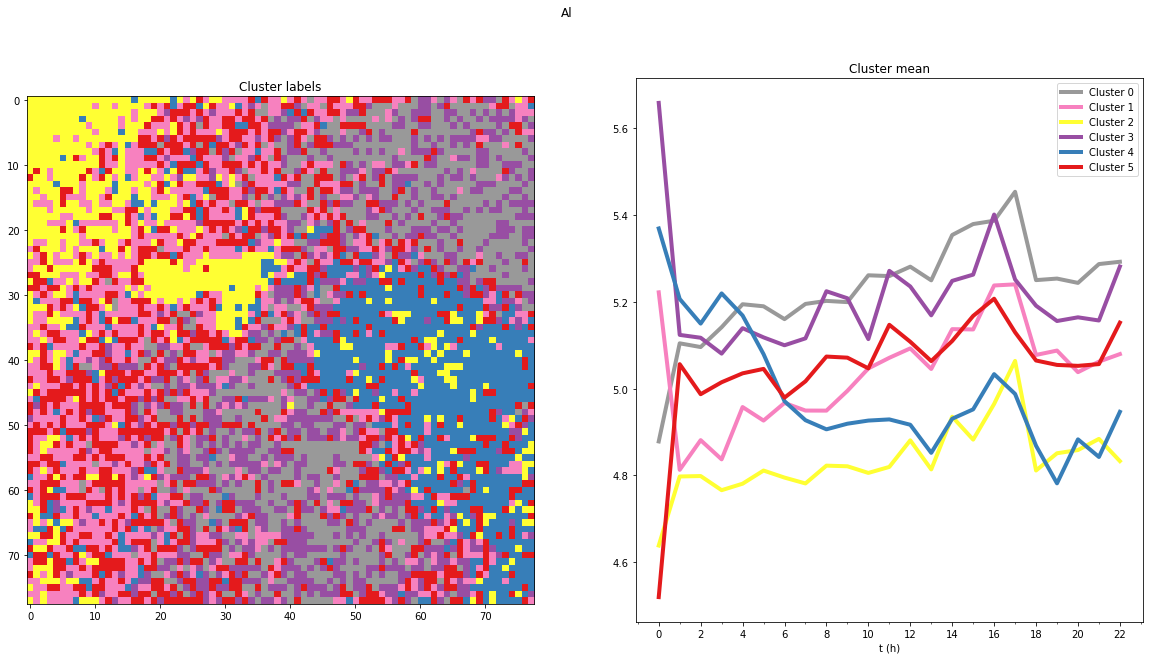

In [86]:
plot_cluster_results(Al_cluster_model, hours, images['Al-Ka'][0].shape, 'Al')

In [100]:
def plot_cluster_collage(models, names, time, data_shape, save=False):
    from matplotlib import cm
    import matplotlib.colors as colors
    import matplotlib as mpl
    plt.rcParams['font.size'] = 14

    cmap_ = cm.Set1_r
    plt.figure(figsize=(20,20), dpi=300)
    for idx, model in enumerate(models):
        name = names[idx]

        # Define the normalization for the colormap
        norm = colors.Normalize(vmin=0, vmax=model.labels_.max())
        # Map the cluster labels to colors using the colormap and normalization
        cluster_colors = cmap_(norm(model.labels_.reshape([data_shape[0], data_shape[1]])))
    
        plt.subplot(2,2,idx+1)
        plt.imshow(cluster_colors, cmap=cmap_)
        plt.title(f'Cluster labels {name}')

        plt.subplot(2,2,idx+3)

        for idx,center in enumerate(model.cluster_centers_):
            plt.plot(hours[window_size-1:], center.T, label=f'Cluster {idx}', color=cmap_(norm(idx)), linewidth=4)
        plt.xlabel('t (h)')
        plt.ylabel('Mean intensity (a.u.)')
        plt.title(f'Cluster mean {name}')
        ax = plt.gca()
        ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
        ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
        
        plt.legend()
        if save:
            plt.savefig(f'figures/clustering_{names}_{scan_detail}.png', transparent=False, bbox_inches='tight', )


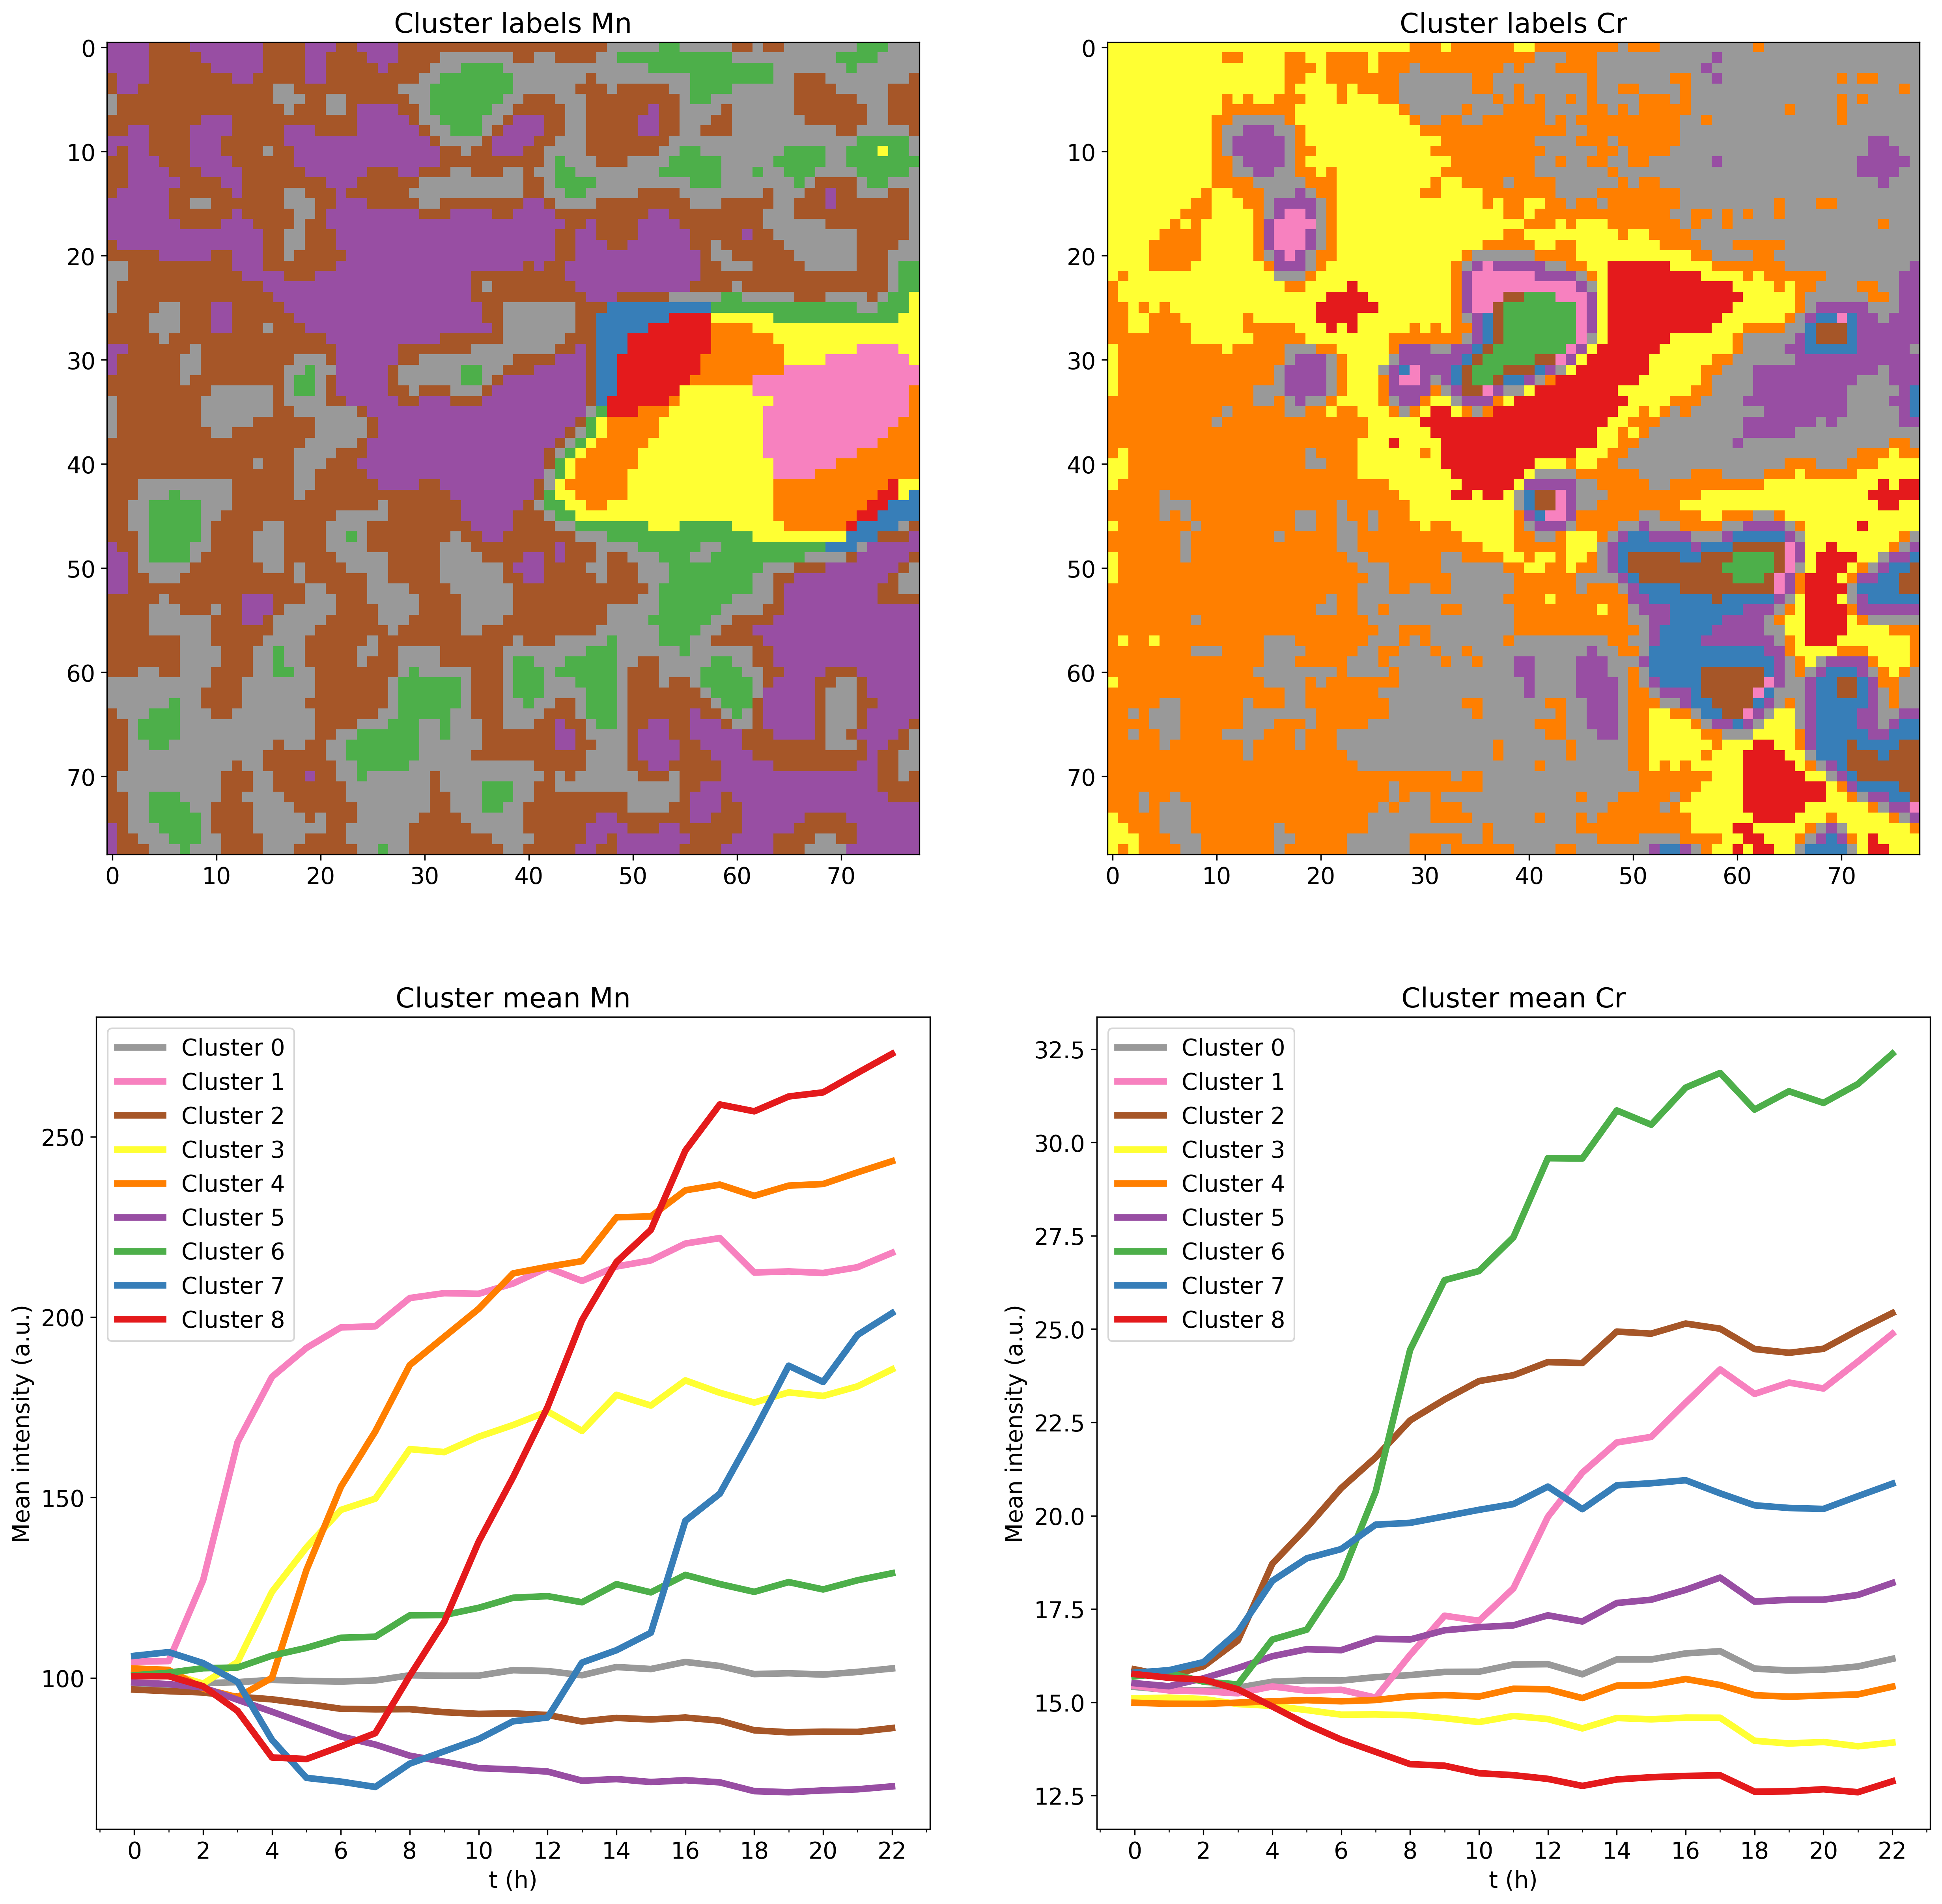

In [101]:
plot_cluster_collage([Mn_cluster_model, Cr_cluster_model], ['Mn', 'Cr'], hours, images['Mn_Ka'][0].shape, save=True)


In [105]:
Mn_distances = Mn_cluster_model.transform(smoothed_Mn.T)

In [108]:
Mn_distances.shape

(6084, 9)

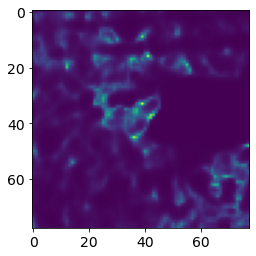

In [120]:
label = 5
weights = 1/(Mn_distances+1)**2
plt.imshow(weights[:,label].reshape(images['Mn_Ka'][0].shape))